- This notebook started as research for forest_fire news coverage
- it's kept for documentation purposes: what does it look like to retrieve products from the archive?

In [ ]:
from sentinel_helpers import search_osm
from sentinel_helpers import geodataframe_on_map
from datetime import date
import os
from sentinelsat import SentinelAPI

api = SentinelAPI(os.getenv('SCIHUB_USERNAME'), os.getenv('SCIHUB_PASSWORD'))

In [4]:
jueterbog = search_osm('Jüterbog, Brandenburg')
jueterbog = jueterbog[(jueterbog['type'] == 'administrative') & (jueterbog['osm_type'] == 'relation')]
jueterbog

,place_id,osm_type,osm_id,display_name,place_rank,category,type,importance,icon,geometry
0,257891092,relation,422436,"Jüterbog, Teltow-Fläming, Brandenburg, 14913, ...",16,boundary,administrative,0.685236,https://nominatim.openstreetmap.org/ui/mapicon...,"POLYGON ((12.95605 52.03939, 12.96134 52.03944..."


In [5]:
geodataframe_on_map(jueterbog)

- we increase the geometry size by 2.5km in each direction

In [22]:
import geopandas as gpd

buffered = jueterbog.to_crs('epsg:25833').buffer(2500).to_crs('epsg:4326')
geodataframe_on_map(buffered)

- now we search for products in the relevant time frame

In [23]:

start_date = date(2018, 7, 1)
end_date = date(2018, 8, 31)

In [29]:

footprint = buffered.iloc[0].convex_hull.wkt

In [30]:
results = api.query(footprint,
                    platformname='Sentinel-2',
                    processinglevel='Level-2A',
                    date=(start_date, end_date),
                    cloudcoverpercentage=(0, 30))

<AxesSubplot:xlabel='beginposition'>

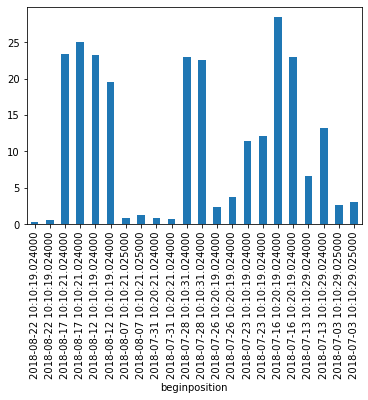

In [39]:
gdf = SentinelAPI.to_geodataframe(results)
gdf.set_index('beginposition')['cloudcoverpercentage'].plot(kind='bar')

- to calculate dNBR you need an image shortly before and shortly after the fire

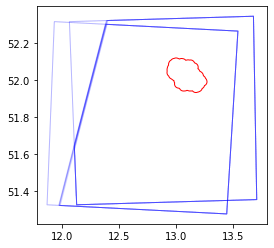

In [43]:
from sentinel_helpers import plot_all

plot_all([
    gdf, buffered
], [
    { 'facecolor': 'none', 'edgecolor': 'blue', 'alpha': 0.1 },
    { 'facecolor': 'none', 'edgecolor': 'red' }
])

- we take the images at the beginning, during the fire and after the fire
- we only take one tile because they all cover the area well

In [59]:
gdf['tile'] = gdf['title'].apply(lambda t: t.split('_')[5])
gdf = gdf[gdf['tile'] == 'T32UQC']
gdf = gdf.sort_values(by='beginposition')

before = gdf.iloc[0]
during = gdf.loc['ad590142-a9f2-49a8-8be7-2a6c06454514'] # this is taken from the printed dataframe above
after = gdf.iloc[-1]

In [67]:
downloads, initialized, failed = api.download_all([before['uuid'], during['uuid'], after['uuid']])

In [71]:
downloads

{}

In [72]:
initialized

{'3506220d-5b7e-4e7a-a3a7-01d272cb5d26': {'id': '3506220d-5b7e-4e7a-a3a7-01d272cb5d26',
  'title': 'S2B_MSIL2A_20180703T101029_N0208_R022_T32UQC_20180703T145931',
  'size': 993411628,
  'md5': '0D93BA047833391172FD8B225E803C27',
  'date': datetime.datetime(2018, 7, 3, 10, 10, 29, 25000),
  'footprint': 'POLYGON((11.977099413076383 51.32472577627447,11.994731157159846 51.36762213853489,12.055061629611966 51.513432056907135,12.115427796855911 51.65922453067321,12.176098601701987 51.80496081562056,12.237329664976563 51.950657514587945,12.298786150689434 52.096349964051925,12.3603752724967 52.24204550642036,12.384930178970409 52.299737130429605,13.539979680877822 52.26313739791785,13.442095184333063 51.27892518278613,11.977099413076383 51.32472577627447))',
  'url': "https://scihub.copernicus.eu/apihub/odata/v1/Products('3506220d-5b7e-4e7a-a3a7-01d272cb5d26')/$value",
  'Online': False,
  'Creation Date': datetime.datetime(2018, 7, 3, 18, 8, 57, 716000),
  'Ingestion Date': datetime.dateti

In [73]:
failed

{'ad590142-a9f2-49a8-8be7-2a6c06454514': {'id': 'ad590142-a9f2-49a8-8be7-2a6c06454514',
  'title': 'S2A_MSIL2A_20180728T101031_N0208_R022_T32UQC_20180728T132514',
  'size': 981847648,
  'md5': '012461B4865515B6EC78E09FF4AC91EC',
  'date': datetime.datetime(2018, 7, 28, 10, 10, 31, 24000),
  'footprint': 'POLYGON((11.974785982028196 51.32479810174945,12.002441117705246 51.39206582453723,12.063020073618857 51.537961187081926,12.123890293708246 51.68386315912,12.184952232955526 51.82975048038856,12.24633772850238 51.975531385227455,12.307978784112072 52.121253595050256,12.369726217769836 52.26691782002904,12.383685377764667 52.29977657409941,13.539979680877822 52.26313739791785,13.442095184333063 51.27892518278613,11.974785982028196 51.32479810174945))',
  'url': "https://scihub.copernicus.eu/apihub/odata/v1/Products('ad590142-a9f2-49a8-8be7-2a6c06454514')/$value",
  'Online': False,
  'Creation Date': datetime.datetime(2018, 7, 28, 21, 42, 40, 577000),
  'Ingestion Date': datetime.dateti

In [74]:
len(downloads), len(initialized), len(failed)

(0, 1, 2)

- one of the failed products could be downloaded several days later
- the other (`0db8938c-7e2c-416d-a41a-5e78544e45c8`) has been initialized several days later